# Anime genre preiction
## Goal
Our main goal is to predict anime genres using synopsis
## Formalize
Input: <b>Synopsis text</b> \
Output: <b>List of predicted genres</b>



# Method
To achieve this we will use Convolutional Neural Network: with several hidden layers

## Steps
1. Vectorize text
2. Get probabilities for each genre
3. Filter probabilies using confidence layer



# Step 0. Preparation
We will start by importing main libraries and defining base functions

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
DATASET_FILENAME = 'anime.csv'
anime_data = pd.read_csv(DATASET_FILENAME);
anime_data

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...
...,...,...,...,...,...,...,...,...,...,...,...,...
19306,32979,Flip Flappers,Cocona is an average middle schooler living wi...,"['Sci-Fi', 'Adventure', 'Comedy', 'Magic']","Oct 6, 2016 to Dec 29, 2016",13.0,134252,843,1070.0,7.73,https://cdn.myanimelist.net/images/anime/4/822...,https://myanimelist.net/anime/32979/Flip_Flappers
19307,123,Fushigi Yuugi,"While visiting the National Library, junior-hi...","['Adventure', 'Fantasy', 'Magic', 'Martial Art...","Apr 6, 1995 to Mar 28, 1996",52.0,84407,1292,1071.0,7.73,https://cdn.myanimelist.net/images/anime/2/201...,https://myanimelist.net/anime/123/Fushigi_Yuugi
19308,1281,Gakkou no Kaidan,"Years ago, all of the ghosts in a haunted scho...","['Mystery', 'Horror', 'Supernatural']","Oct 22, 2000 to Mar 25, 2001",19.0,83093,1314,1073.0,7.73,https://cdn.myanimelist.net/images/anime/9/183...,https://myanimelist.net/anime/1281/Gakkou_no_K...
19309,450,InuYasha Movie 2: Kagami no Naka no Mugenjo,Inuyasha and company have finally destroyed Na...,"['Action', 'Adventure', 'Comedy', 'Historical'...","Dec 21, 2002",1.0,71989,1469,1077.0,7.73,https://cdn.myanimelist.net/images/anime/1162/...,https://myanimelist.net/anime/450/InuYasha_Mov...


In [4]:
# Now normalize dataset
print('Filtering dataset')
anime_data_filtered = anime_data.copy(deep=True)

print(f"Before: {len(anime_data_filtered)}")

# Remove duplicated titles
anime_data_filtered = anime_data_filtered[~anime_data_filtered['title'].duplicated()]

# Remove null or empty synopsises
anime_data_filtered = anime_data_filtered[~(anime_data_filtered['synopsis'].isnull() | anime_data_filtered['synopsis'].isna() | anime_data_filtered['synopsis'].str.len() == 0)]

# Cast all synopsis to string - remove null and NaN
anime_data_filtered['synopsis'] = anime_data_filtered['synopsis'].apply(str)

# Remove unset synopsises
anime_data_filtered = anime_data_filtered[~anime_data_filtered['synopsis'].str.contains('No synopsis provided yet')]

# Remove unique
anime_data_filtered = anime_data_filtered.groupby('genre').filter(lambda x: len(x) > 1)

# Extract list of genres from array string 
anime_data_filtered['genre'] = anime_data_filtered['genre'].apply(lambda x: literal_eval(x))

print(f'After: {len(anime_data_filtered)}')

Filtering dataset
Before: 19311
After: 13080


In [5]:
# Split dataset into train and test sets
test_size = 0.3
train_df, test_df = train_test_split(anime_data_filtered, test_size=test_size, stratify=anime_data_filtered['genre'].values)

# Create validation dataset
validation_df = train_df.sample(frac=0.5)
train_df.drop(index=validation_df.index, inplace=True)

# Step 1. Text vectorization

Firstly, we will vectorize genres of anime

In [6]:
# Vectorize genres using hot encoding
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(tf.ragged.constant(anime_data_filtered['genre'].values))
vocabulary = lookup.get_vocabulary()
# Will be used further
GENRES_COUNT = len(vocabulary)
vocabulary

['[UNK]',
 'Comedy',
 'Action',
 'Kids',
 'Fantasy',
 'Adventure',
 'Music',
 'Sci-Fi',
 'Drama',
 'Slice of Life',
 'Shounen',
 'Hentai',
 'School',
 'Romance',
 'Mecha',
 'Supernatural',
 'Historical',
 'Magic',
 'Sports',
 'Seinen',
 'Parody',
 'Shoujo',
 'Ecchi',
 'Super Power',
 'Dementia',
 'Mystery',
 'Military',
 'Space',
 'Demons',
 'Game',
 'Harem',
 'Horror',
 'Martial Arts',
 'Police',
 'Psychological',
 'Samurai',
 'Cars',
 'Vampire',
 'Shounen Ai',
 'Josei',
 'Thriller',
 'Shoujo Ai',
 'Yuri',
 'Yaoi']

In [7]:
# Define helper function to represent encoded genres to human readable strings
def encoded_labels_to_decoded_genres_string_array(encoded):
  indices = np.argwhere(encoded == 1.0)[..., 0]
  return np.take(vocabulary, indices)

Find out mean words count in each synopsis to fit our vocabulary

In [8]:
train_df['synopsis'].apply(lambda s: s.split(' ')).describe()

count    4578.000000
mean       59.268895
std        57.260025
min         1.000000
25%        14.000000
50%        40.000000
75%        88.000000
max       439.000000
Name: synopsis, dtype: float64

For my selection I got unqie ~4000 words.
I will use 2000 word for vocabulary to make model more flexible.

In [9]:
max_words_count = 2000
batch_size = 32

def make_dataset(original, is_train=False):
  labels = tf.ragged.constant(original['genre'].values)
  labels_binarized = lookup(labels).numpy()
  dataset = tf.data.Dataset.from_tensor_slices((original['synopsis'].values, labels_binarized))
  if not is_train:
    dataset = dataset.shuffle(batch_size * 10)
  return dataset.batch(batch_size)

In [10]:
train_ds = make_dataset(train_df, is_train=True)
validation_ds = make_dataset(validation_df)
test_ds = make_dataset(test_df)

In [11]:
text_batch, label_batch = next(iter(train_ds))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Synopsis: {text}")
    print(f"Genre(s): {encoded_labels_to_decoded_genres_string_array(label[0])}")
    print()

Synopsis: b"The Angelic Guard, who call the heavens their home, have been tasked with collecting the orbs scattered across the world. Lucifer\xe2\x80\x94a leader of the Angelic Guard with a rebellious streak, said to wield power rivaling the Almighty\xe2\x80\x94carries out her duty along with Uriel, also a leader of the guard. Together, they go about executing their mission, until Holy Magistrate Keter\xe2\x80\x94the one who leads the heavens under the Almighty's will\xe2\x80\x94tells Uriel of Lucifer's planned rebellion. Initially in disbelief, Uriel then learns that the accusations against Lucifer may be connected to an event that once threatened to shatter the heavens. \n \n(Source: Official YouTube Channel)"
Genre(s): ['Action' 'Fantasy' 'Game']

Synopsis: b'First movie of Magical Taruruuto-kun'
Genre(s): ['Comedy' 'Fantasy' 'Adventure' 'School' 'Magic' 'Ecchi']

Synopsis: b'SoulTaker DVD specials featuring Komugi. '
Genre(s): ['Comedy']

Synopsis: b'DVD bundled with the limited ed

Now we will vectorize actual synopsises in datasets

In [12]:
def get_vocabulary(dataset) -> set:
  vocabulary = set()
  dataset.str.lower().str.split().apply(vocabulary.update)
  return vocabulary

In [13]:
words_vocabulary = get_vocabulary(train_df['synopsis'])
max_tokens = len(words_vocabulary)
print(f'Size of result vocabulary is {len(words_vocabulary)}')

Size of result vocabulary is 37341


In [15]:
# Create text vectorization layer for CNN
text_vectorizer = layers.TextVectorization(
    max_tokens=max_tokens, ngrams=2, output_mode='tf_idf'
)

In [16]:
# This code sheet was taken from Keras documentation
# I think I shouldn't remove such optimization 
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_ds.map(lambda text, label: text))

In [17]:
def get_prepaired_dataset(nlp_dataset):
  return nlp_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [18]:
train_ds = get_prepaired_dataset(train_ds)
validation_ds = get_prepaired_dataset(validation_ds)
test_ds = get_prepaired_dataset(test_ds)

For not we got our synopsis and genre columns vectorized.

Now it's time to create main model. 


# Step 2. Training


To get probabilities for given synopsis - we will use CNN (Controversial Neural Network) with 2 hidden layers. \
General architecture consists of next layers:
1. Input layer - vector with size of vocabulary
2. Hidden layer with 512 neurons. Activation function - ReLU
3. Hidden layer with 512 neurons. Activation function - ReLU
4. Hidden layer with 512 neurons. Activation function - ReLU
5. Output layer - vector with size of total genres count.

Mention 2 points:
1. Input layer get vector with if_idf coefficients
2. Output layer has to be probability. So activation function will be 'sigmoid'. We can not use 'softmax' as it will give only 1 label with probability higher than 0.5


Define function to initialize such model

In [19]:
def initialize_base_model():
  base_model = keras.Sequential(
      [
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(lookup.vocabulary_size(), activation='sigmoid'),
      ]
  )
  return base_model

Now, train base model

In [20]:
epochs = 15

model = initialize_base_model()
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy']
)

train_history = model.fit(
    train_ds, validation_data=validation_ds, epochs=epochs
)

Epoch 1/15
144/144 [==============================] - 39s 263ms/step - loss: 0.1969 - categorical_accuracy: 0.3626 - val_loss: 0.1508 - val_categorical_accuracy: 0.4170
Epoch 2/15
144/144 [==============================] - 40s 279ms/step - loss: 0.0810 - categorical_accuracy: 0.5607 - val_loss: 0.1660 - val_categorical_accuracy: 0.4093
Epoch 3/15
144/144 [==============================] - 38s 263ms/step - loss: 0.0477 - categorical_accuracy: 0.5688 - val_loss: 0.2006 - val_categorical_accuracy: 0.2912
Epoch 4/15
144/144 [==============================] - 38s 263ms/step - loss: 0.0357 - categorical_accuracy: 0.5649 - val_loss: 0.2037 - val_categorical_accuracy: 0.3366
Epoch 5/15
144/144 [==============================] - 38s 263ms/step - loss: 0.0286 - categorical_accuracy: 0.5496 - val_loss: 0.1996 - val_categorical_accuracy: 0.3132
Epoch 6/15
144/144 [==============================] - 38s 262ms/step - loss: 0.0220 - categorical_accuracy: 0.5535 - val_loss: 0.2122 - val_categorical_acc

In [21]:
def plot_result(history, indicator):
  plt.plot(history.history[indicator], label=indicator)
  plt.plot(history.history["val_" + indicator], label="val_" + indicator)
  plt.xlabel('Epochs')
  plt.ylabel(indicator)
  plt.title(f"Train and Validation {indicator} Over Epochs", fontsize=14)
  plt.legend()
  plt.grid()
  plt.show()

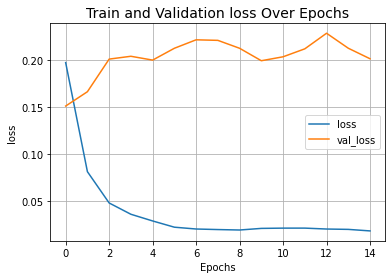

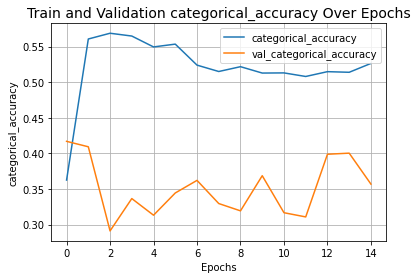

In [22]:
plot_result(train_history, 'loss')
plot_result(train_history, 'categorical_accuracy')

In [23]:
test_categorical_loss, test_categorical_accuracy = model.evaluate(test_ds)
print('Loss:', test_categorical_loss)
print('Accuracy:', test_categorical_accuracy)


123/123 [==============================] - 8s 62ms/step - loss: 0.1982 - categorical_accuracy: 0.3642
Loss: 0.1981842964887619
Accuracy: 0.3641692101955414


At this point we can get probabilities for each genre for given synopsis. \
Next step is to find best level of confidence to accept genre.

# Step 3. Filter probabilies using confidence layer

To find confidence layer we will use simple logistic regression.
 
From previous step we got vector of probabilities, which will use to train our next model

First, create inference model combining text_vectorizer and actual CNN. \
For the test data we will use test dataset from previous step

In [24]:
inference_model = keras.Sequential([text_vectorizer, model])

## Simple predictor

Let's start with simple predictor: accept genre if it's probability greater than 0.5 and for those who left without genre we will use genre with max probability

In [25]:
accept_level = 0.4

def get_genres_simple(probabilities):
  zipped = zip(probabilities, lookup.get_vocabulary())
  
  result = []
  for pair in zipped:
    if pair[0] >= accept_level:
      result.append(pair[1]) 
  if len(result) == 0:
    maximum = (0, '')
    for pair in zipped:
      if int(pair[0]) > int(maximum[0]):
        maximum = pair
    result.append(maximum[1])
  return result

In [26]:
# Test on dataset
inference_ds = make_dataset(test_df.sample(frac=0.5))
synopsis_batch, genres_batch = next(iter(inference_ds))

predicted_genres_probabilities = inference_model.predict(synopsis_batch)

# Test on random 10 examples
for i, synopsis in enumerate(synopsis_batch[:10]):
    actual_genres = genres_batch[i].numpy()[None, ...]
    print(f"Actual genres: {encoded_labels_to_decoded_genres_string_array(actual_genres[0])}")
    predicted_genres = get_genres_simple(predicted_genres_probabilities[i])
    print(f'Predicted genres: {predicted_genres}')
    print()

Actual genres: ['Slice of Life' 'Romance']
Predicted genres: ['Drama', 'School', 'Romance']

Actual genres: ['Dementia' 'Horror' 'Psychological']
Predicted genres: ['Fantasy', 'Adventure', 'Shounen']

Actual genres: ['Comedy' 'Kids']
Predicted genres: ['Comedy', 'Kids']

Actual genres: ['Comedy' 'Kids']
Predicted genres: ['Kids', 'Sports']

Actual genres: ['Hentai']
Predicted genres: ['Action', 'Fantasy', 'Adventure']

Actual genres: ['Comedy' 'Kids']
Predicted genres: ['Comedy']

Actual genres: ['Hentai' 'School']
Predicted genres: ['Kids', 'Hentai']

Actual genres: ['Hentai']
Predicted genres: ['Kids']

Actual genres: ['Hentai']
Predicted genres: ['Hentai']

Actual genres: ['Kids' 'Magic' 'Shoujo']
Predicted genres: ['Comedy', 'Fantasy', 'Magic']



Results:
- Advantages: 
  - Simplicity
- Disadvantages:
  - Low accuracy

To achieve better accuracy - we will use logistic regression.

## Logistic regression

Every probability is independent for each other. \
So our goal is to create regression for each genre and then put them together

In [27]:
from sklearn import linear_model
from joblib import Parallel, delayed

Formalize:
- Input: **array of probabilities**
- Output: **genre indicator array**

Example: 
- [0.32, 0.65, 0.02] -> [1, 1, 0]

Our main goal is to find level of probability for each genre to accept belonging to it. \
So, as for architecture we will use array of independent logistic regression models trained for each genre independently

In [28]:
# Get genres probabilities for each train dataframe used previously
logistic_ds = make_dataset(train_df)
predicted_probabilities_array, actual_genres_array = [], []
for synopsis_batch, genres_batch in logistic_ds:
  predicted_probabilities_batch = inference_model.predict(synopsis_batch)
  for i, synopsis in enumerate(synopsis_batch):
    actual_genres_array.append(genres_batch[i].numpy())
    predicted_probabilities_array.append(predicted_probabilities_batch[i])


In [29]:
# Fit into buckets for each genre
genres_df = [[[] for _ in range(2)] for _ in range(GENRES_COUNT)]
for pred_probs, actual_genres in zip(predicted_probabilities_array, actual_genres_array):
  for i in range(GENRES_COUNT):
    genres_df[i][0].append(pred_probs[i])
    genres_df[i][1].append(actual_genres[i])

# Example:
# genres_df[1][0] - X values (probabilities) for genre with index 1
# genres_df[5][1][7] - Does 7 sample with genre at 5 index actually has it genre

Now, we have probabilities and actual genres (indicators). \
It's time to train our logistic models. \
As we can see, models are independent and to increate time of learning we will parallize it

In [30]:
def train_probability_logistic_model(X, y, i):
  if i == 0:
    return
  X = np.array(X).reshape(-1, 1)
  y = np.array(y).reshape(-1, 1)
  logistic_model = linear_model.LogisticRegression()
  logistic_model.fit(X, y)
  return logistic_model

logistic_models = Parallel(n_jobs=GENRES_COUNT)(delayed(function=train_probability_logistic_model)(genres_df[i][0], genres_df[i][1], i) for i in range(GENRES_COUNT))

# Fix broken 'UNK' class that has only 0
logistic_models[0] = linear_model.LogisticRegression()

Let's test our model

In [31]:
def predict_genre_belonging(prob, i):
  if i == 0:
    return 0.0
  return logistic_models[i].predict([prob])[0]
def get_genres_logistic(probabilities):
  results = Parallel(n_jobs=GENRES_COUNT)(delayed(predict_genre_belonging)(probabilities[i], i) for i in range(GENRES_COUNT))
  return encoded_labels_to_decoded_genres_string_array(results)


# Step 4. Wrapping up

We have trained CNN and logistic predicted. 
Now, we must connect them together to make better predictions.

We will make it using class in python:
- It will contain main method: 'predictGenres'

In [32]:
class AnimePredictor:
  def __init__(self, cnn, regressions):
    self.genres_count = len(regressions)
    self.cnn = cnn
    self.regressions = regressions

  def get_genres_logistic(self, probabilities):
    results = [self.regressions[i].predict([[probabilities[i]]])[0] if i != 0 else 0.0 for i in range(len(probabilities))]
    results = np.array(results).reshape(-1, 1)
    return encoded_labels_to_decoded_genres_string_array(results)
  
  def predictGenres(self, synopsis: str) -> list:
    predictions_raw = self.cnn.predict([synopsis])
    predictions_logistic = self.get_genres_logistic(predictions_raw[0])
    # predictions_logistic = encoded_labels_to_decoded_genres_string_array(np.array([1 if i > 0.3 else 0 for i in predictions_raw]).reshape(-1, 1))
    return list(predictions_logistic)

In [33]:
anime_predictor = AnimePredictor(cnn=inference_model, regressions=logistic_models)

For manual testing, I have chosen Gintama: The Final. 

More about: https://myanimelist.net/anime/39486/Gintama__The_Final

In [34]:
gto_genres_actual = ['Action', 'Comedy', 'Drama', 'Sci-Fi']
gto_genres_actual.sort()
gto_genres_predicted = anime_predictor.predictGenres("""Two years have passed following the Tendoshuu's invasion of the O-Edo Central Terminal. Since then, the Yorozuya have gone their separate ways. Foreseeing Utsuro's return, Gintoki Sakata begins surveying Earth's ley lines for traces of the other man's Altana. After an encounter with the remnants of the Tendoshuu—who continue to press on in search of immortality—Gintoki returns to Edo.

Later, the regrouped Shinsengumi and Yorozuya begin an attack on the occupied Central Terminal. With the Altana harvested by the wreckage of the Tendoshuu's ship in danger of detonating, the Yorozuya and their allies fight their enemies while the safety of Edo—and the rest of the world—hangs in the balance. Fulfilling the wishes of their teacher, Shouyou Yoshida's former students unite and relive their pasts one final time in an attempt to save their futures.""")
gto_genres_predicted.sort()
print('"Gintama: The Final"')
print('Actual genres: ', ', '.join(gto_genres_actual))
print('Predicted genres: ', ', '.join(gto_genres_predicted))
common = list(set(gto_genres_predicted) & set(gto_genres_actual))
common.sort()
print('Common: ', ', '.join(common))

"Gintama: The Final"
Actual genres:  Action, Comedy, Drama, Sci-Fi
Predicted genres:  Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen
Common:  Action, Comedy, Sci-Fi


For given anime 'Great Teacher Onizuka' we got genres Comedy, School and Romance. And anime itself has same genres.

# Results

Now we have our model done and it's accuracy is good enough to predict genres.

**Future improvements**:
- Give most similar anime based on given genres
- Update CNN architecture to predict better

**Links**:
- Dataset: https://drive.google.com/file/d/1lojVW_IxaWKKtujWwXktfgprQlkKJeFs/view?usp=sharing

## P.S. Serialization

Now, let's serialize our model to use it in other projects

In [ ]:
import pickle

In [ ]:
MODEL_FILENAME = 'anime_predictor_model.sav'
with open(MODEL_FILENAME, 'wb') as f:
  pickle.dump(anime_predictor, f)

OSError: ignored